# Junior Applied Machine Learning Technical Test

**Hello! Thanks for applying for the Junior Machine Learning position in Red Points. This is the technical challenge for this position. It consists of two parts: a coding and a discussion challenge.**

### Coding Test: Listing title classifier

**In Red Points we handle many online infringements provided by automatic online search bots. These bots extract from the different websites the titles for all the listings found online.**

**For example, imagine that we have a protected product called: “dji mavic pro”. Bots start searching and retrieve many listings, providing us with this titles:**

* **DJI Mavic Pro Clone Drone With Wifi FPV 1080P HD Camera Foldable RC Quadcopter ✔**
* **DJI MAVIC PRO FLY MORE COMBO con Garanzia Attiva + Eliche Platinum + Accessori**
* **dji mavic pro fly SPECIAL White Edition**
* **Vectorsave 10 Mavic RS paracaídas sistema para DJI Mavic drones**

**Some of them belong to the protected product, and some of them don’t (the listings sell accessories instead of the main product, they sell a different product or a different model that the one we are protecting). Given this information, we propose the following problem:**

**1. Design a text classifier which will be able to classify a listing title in two categories: ASSET or NON-ASSET (is the product or not, respectively). For this, we provide three datasets for three different products, so you have examples of the kind of data that the bots provide. The data has been already labeled by some users. You should create a single model for each product using the same method: same algorithm, different data.**

**2. Try at least two or three methods to do this, and compare the results, explaining the advantages and disadvantages for each method. Additionally, provide at least one graphic with the algorithm comparison.**

- Two different approaches for feature extraction have been used. A first approch, based on text characteristics, which traverses the text to count different metrics (words density, digits, uppercase words, etc) and a second approach, based of TF-IDF (instead of a more simpler bag of words) in order to account for less recurrent words to have higher meaning when contructing the feature vectors. 

- On each approach, four different algorithms have been used. Due to the amount of data, the choosen algorithms do not include methods which allow for more complexity to be learnt (e.g: ANN).

The four choosen algorithms are the following:
1. Naive Bayes classifier
    + Fast training and prediction. Low CPU / memory usage.
    - As the name suggests "Naive" for taking into account possible relationships between features.
    - Sensitive to other distributions than guassian.


2. Support Vector classifier
    + Scalable for higher dimenisional datasets.
    + Memory eficient
    - Reduced performance on overlapping target classes.
    - Small interepretability (points on one side or other of a line).
    - Small impact from outliers (Only support vectors decision).


3. Random forest classifier
    + Avoid overfitting due to the combination of multiple decission trees.
    + Able to represent complex data (simple NN alike), even with small datasets.
    + Do not require preparation of the input data.
    - Time / resource consuming to train.
    - Less interpretable than single decision trees.

**3. (Optional) Take into account training and prediction time. How long does the algorithm take to train and predict? Does your selected algorithm work properly under heavy time constraints?**

1. Naive Bayes classifier
    + Fast training (only priors and likelyhoods have to be computed).
    + Fast prediction (posterior computation and max prob). Scales linearly.


2. Support Vector classifier (linear)
    + Training based on estimating weights and biases solving a quadratic problem.
    + Fast prediction (Constant on the input dimensions)


3. Random forest classifier
    + Slow training (several trees have to be made, including the randomisation)
    + Slow prediction (Each tree needs to be accessed)


**Please provide the code and results in a Jupyter/google colab notebook, in a github project.**

# Imports 

In [120]:
import glob
# import keras

import html

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn import model_selection, preprocessing, metrics, svm, ensemble, linear_model
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import string

### Dataset reading

Mavic dataset appears to have some misplaced columns with the value "dji mavic pro". In order to make the dataset fully readable, that column has been removed beforehand.

In [121]:
dataset_folder = "ratings"
dataset_files = glob.glob(dataset_folder + "/*.dat")
datasets = []

for data_file_path in dataset_files:
    datasets.append(pd.read_csv(data_file_path, sep='\t', header=None))


In [122]:
for dataset in datasets:
    print(dataset.shape)

(5335, 3)
(5612, 3)
(696, 3)


### Dataset preprocessing (if needed)

#### Dropping duplicates

In [123]:
for dataset in datasets:
    print(dataset.shape)

(5335, 3)
(5612, 3)
(696, 3)


In [124]:
datasets = [dataset.drop_duplicates() for dataset in datasets]

In [125]:
for dataset in datasets:
    print(dataset.shape)

(1310, 3)
(315, 3)
(696, 3)


#### Convert HTML entities found in text

A first inspection on the dataset showed that some html entities where present on the text as plain text (unescaped). 

In [131]:
datasets[0][1] = datasets[0][1].apply(html.unescape)
datasets[1][1] = datasets[1][1].apply(html.unescape)
datasets[2][1] = datasets[2][1].apply(html.unescape)

### Text features compilation

In [160]:
def check_pos_tag(x, flag):
    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adj': ['JJ', 'JJR', 'JJS'],
        'adv': ['RB', 'RBR', 'RBS', 'WRB']
    }

    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

def compute_text_features(dataset):
    dataframe = pd.DataFrame()
    dataframe['char_count'] = dataset[1].apply(lambda x: sum(c.isalpha() for c in x))
    dataframe['digit_count'] = dataset[1].apply(lambda x: sum(c.isdigit() for c in x))
    dataframe['word_count'] = dataset[1].apply(lambda x: len(x.split(" ")))
    dataframe['word_density'] = dataset[1].apply(len) / (dataframe['word_count'] + 1)
    dataframe['punctuation_count'] = dataset[1].apply(
        lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
    dataframe['title_word_count'] = dataset[1].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    dataframe['upper_case_word_count'] = dataset[1].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    
    '''
    dataframe['noun_count'] = dataset[1].apply(lambda x: check_pos_tag(x, 'noun'))
    dataframe['verb_count'] = dataset[1].apply(lambda x: check_pos_tag(x, 'verb'))
    dataframe['adj_count'] = dataset[1].apply(lambda x: check_pos_tag(x, 'adj'))
    dataframe['adv_count'] = dataset[1].apply(lambda x: check_pos_tag(x, 'adv'))
    dataframe['pron_count'] = dataset[1].apply(lambda x: check_pos_tag(x, 'pron'))
    '''
    dataframe['ASSET'] = dataset[2]

    return dataframe

### Spliting datasets and training

Due to the amount of data available after preprocessing a 10-fold stratified cross-validation for partitioning the data and traning the models has been used, since it would be beneficial over a simple dual test / train approach due to the limited data and could result in a less biassed model (every data appears as test and train). At traning / test time, the decision class is balanced due to the usage of a stratified approach.

In [161]:
def train_model(classifier, text, asset, n_splits):
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
    return [classifier.fit(text[train], asset[train]).score(text[test], asset[test])
     for train, test in k_fold.split(text, asset)]

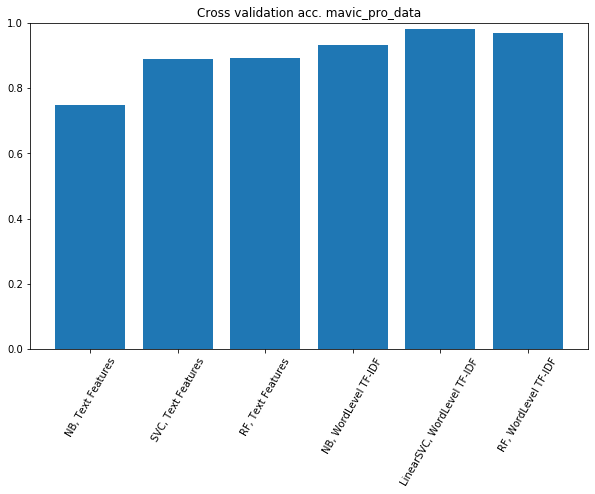

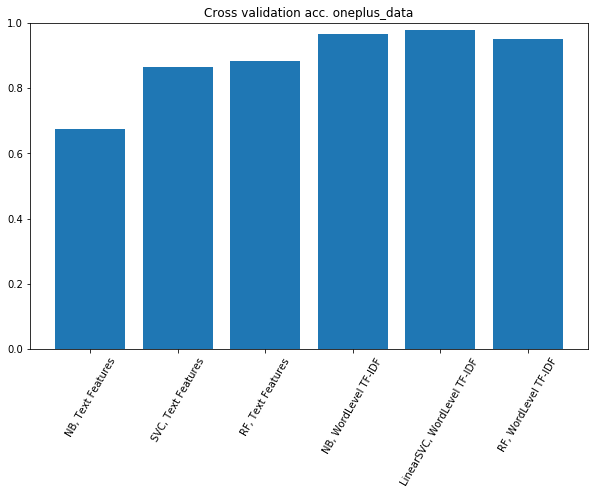

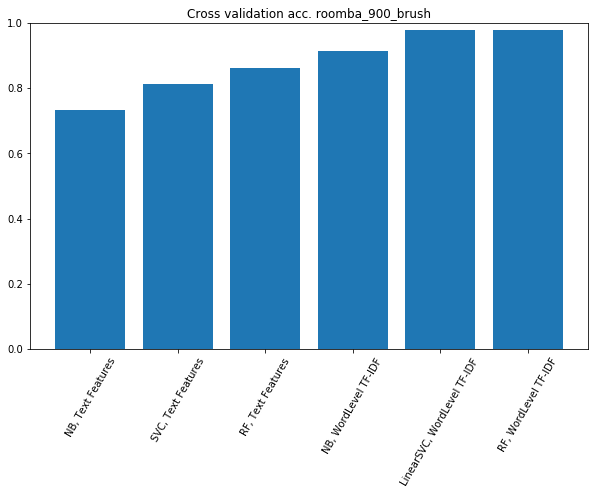

In [182]:
dataset_count = 0
for dataset in datasets:
    
    x_train, x_test, y_train, y_test = train_test_split(dataset[1].to_numpy(),
                                                        keras.utils.to_categorical(dataset[2].to_numpy(),
                                                        num_classes=2), test_size=0.33,
                                                        shuffle=True, random_state=7)
    accuracies_table = []
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(dataset[2])
    
    text_features = compute_text_features(dataset)

    accuracy = train_model(MultinomialNB(), text_features.drop(['ASSET'], axis=1).to_numpy(), y, 10)
    # print("NB, Text features: ", accuracy)
    accuracies_table.append(["NB, Text Features", np.average(accuracy)])
    
    accuracy = train_model(svm.SVC(gamma='auto', max_iter=10000), text_features.drop(['ASSET'], axis=1).to_numpy(), y, 10)
    # print("SVC, Text features: ", accuracy)
    accuracies_table.append(["SVC, Text Features", np.average(accuracy)])

    accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), text_features.drop(['ASSET'], axis=1).to_numpy(), y, 10)
    # print("RF, Text features: ", accuracy)
    accuracies_table.append(["RF, Text Features", np.average(accuracy)])

    # word level tf-idf
    tfidf_vect = TfidfVectorizer(analyzer='word', max_features=50000)
    tfidf_word = tfidf_vect.fit_transform(dataset[1])
    
    accuracy = train_model(BernoulliNB(), tfidf_word.toarray(), y, 10)
    # print("NB, WordLevel TF-IDF: ", accuracy)
    accuracies_table.append(["NB, WordLevel TF-IDF", np.average(accuracy)])

    accuracy = train_model(svm.LinearSVC(max_iter=10000), tfidf_word, y, 10)
    # print("SVC, WordLevel TF-IDF: ", accuracy)
    accuracies_table.append(["LinearSVC, WordLevel TF-IDF", np.average(accuracy)])

    accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=100), tfidf_word, y, 10)
    # print("RF, WordLevel TF-IDF: ", accuracy)
    accuracies_table.append(["RF, WordLevel TF-IDF", np.average(accuracy)])
    
    # fig, ax = plt.subplots()
    x = np.arange(len(accuracies_table))
    accuracies_table = np.array(accuracies_table)

    dataset_name = dataset_files[dataset_count].split('/')[1].split('.dat')[0]
    plt.figure(figsize=(10, 6))
    plt.bar(x, [float(elem[1]) for elem in accuracies_table], )
    plt.xticks(x, [elem[0] for elem in accuracies_table], rotation=60)
    plt.ylim((0, 1))
    plt.title('Cross validation acc. ' + dataset_name)

    #plt.savefig(dataset_accuracies.png')
    plt.show()
    
    dataset_count +=1

### Comenting the results

Despite having lower averaged accuracy than TF-IDF based models, the trained models traning using only text characteristics still show an 80% accuracy whilst having a small dimensionality and not maintaining the actual text. Both SVC and RF based methods are able have a higher accuracy over the naive bayes approach.

For the models traned with text features all of them did show an acuracy over 90%. However it must be highlighted that naive bayes, despite been a really simple method (compared to the others) did still manage to obtain a decent accuracy.

## Discussion Test: Search queries generator

**No code is needed for this part, although you might sketch your ideas or explain in the same notebook.**

**In Red Points automatic online search bots are the responsible for discovering infringing listings online. Bots need to know what to find and how to reach those listings. So for each product that we protect, bots have to be provided with a useful set of search queries so they find the product that we want. These search queries should bring results in each site that they use, having the most ASSET results as they can, with the least NON-ASSET results possible. How would you design this? What algorithms or methods could you use?**

1. Get to study the product text on the company webpage, reviews. Averaged clients ratings aswell.
1. Crawl for online sellers big (amazon, ebay, aliexpress, alibaba, gearbest, taobao etc) and small (through a search engine) for products with the same name description.

1. Study reviews on every different sellers to account for bias due to bad reviews. (1D CNN, (LSTM / GRU), ...)
1. Study # product sales / reviews to account for possible untrusted sellers. 
1. Study product text on different listings. (Similarity with original product #words. Copy pasting).
1. Study price between them, MSRP aswell as tendencies through time. (Gaussian models)

1. Computer vision for determining product similarity through pictures and errors in trademark. (CNN & GAN)
1. Authorised retailers? (product webpage) (URL matching)
1. Crawler using corpus of mispelled product names. (Edit distance)
1. (IDEA) Tracking shipping origin could relate to known refurbishing locations (e.g: shenzen)


**With time, bots continue bringing more and more results, increasing the number of listing titles in the training set. How would you manage the growth of the training set?**

- Using online learning / incremental learning in order to update the model parameters against new data whilst maintaining a checkpoint in order to make sure that the model doesnt get biased.

**Also some fake goods sellers, tired of all their listings being removed, start to change the way the call the items (p.e. fakes of brand MYBRAND start being listed as MYRAND or MINEBRAND in their listings). How would your proposed method handle this changes in naming over time?**

- Using levenstein / edit distance, a spelling corrector would be created in order to adapt possible rebrandings. That spelling corrector would be created using a corpus of possible combinations of 1-to-n distance created words over the actual brand and would change the actual rebranding to the original if needed. 

**Reporting a listing as NON-ASSET makes the system "miss" some results. We prefer to have them in the system and then reject them, instead of not finding them. What metric should you take into account for this?**

* False positives should be taken into account and all the metrics that are constructed from FP as well.

**Finally: How would you change your definition if recall was more important than precision?**

* Focus should be put into making sure that ASSET labeled results don't get missclassified as NON-ASSET.